# Marvel Superheroes - Group 14

## Group Members
* Simone Facchiano
* Stefano Lacommare
* Jonas Barth

# Index

* [Graph Setup](#Graph-Setup)
    * [Collaborative Graph](#Collaborative-Graph)
    * [Hero-Comic Graph](#Hero-Comic-Graph)
* [Features](#1.-Features)
    * [Functionality](#1.1-Functionality)
    * [Visualisation](#1.2-Visualisation)
* [Find Top Superheroes](#2.-Find-Top-Superheroes)
    * [Functionality](#2.1-Functionality)
    * [Visualisation](#2.2-Visualisation)
* [Shortest Ordered Route](#3.-Shortest-Ordered-Route)
    * [Functionality](#3.1-Functionality)
    * [Visualisation](#3.2-Visualisation)
* [Disconnecting Graphs](#4.-Disconnecting-Graphs)
    * [Functionality](#4.1-Functionality)
    * [Visualisation](#4.2-Visualisation)
* [Exctracting Communities](#5.-Extracting-Communities)
    * [Functionality](#5.1-Functionality)
    * [Visualisation](#5.2-Visualisation)
* [Algorithmic Question](#Algorithmic-Question)

Turn off the logging messages in the notebook

In [27]:
import logging, sys
logging.disable(sys.maxsize)

Use `itables` to make displayed pandas dataframes interactive. 

In [28]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

# Hero Service Setup
The [hero service](backend/service) is a class that exposes information about the **top N** heroes. It only needs to be created **ONCE** at the beginning of the program. Functionalities that need to use this hero service can now access it.

In [29]:
from backend import create_hero_service

create_hero_service(data='data/edges.csv')

# Graph Setup
The graphs are created in the [backend/graph](backend/graph) package. Within this package, there are **two** modules:
- [collaborative](backend/graph/collaborative.py) for creating graphs where heroes are linked to heroes (first graph).
- [hero-comic](backend/graph/hero_comic.py) for creating graphs where heroes are linked to comics (second graph).

Graphs are easily created using the `create_from` function, which can create `networkx` graphs from `.csv` files or `pandas` dataframes. The function returns a tuple of the created graph and its graph type, **collaborative** or **hero-comic**. The function also applies a number of preprocessing steps to the provided data.

## Collaborative Graph

### Preprocessing
The `create_from` function for the collaborative graph applies the following preprocessing steps:

1. remove self loops from the data.
1. strip trailing whitespace and `/` from heroes, e.g. `IRONMAN/TONY STARK/` becomes `IRONMAN/TONY STARK`.
1. replace `SPIDER-MAN/PETER PAR` with `SPIDER-MAN/PETER PARKER`.

### Weight
The collaborative graph is a **weighted** graph, where the weight between the heroes is relative to the **number of collaborations** between them. We have a [weight](backend/graph/weight.py) module with several functions that calculate weights for the edges. The one we chose, will normalise weights into $[0, 1]$ where numbers close to $0$ represent more collaborations between the two heroes that share the edge. 

The equation shows the limit of the weight function that we use. As the number of collaborations $n$ grows to infinity, the weight function will go to $0$ as we subtract the proportion of $n$ over the maximum number of collaborations $max(N)$, where $N$ is the set of all numbers of collaborations.
$$\lim_{n\to\infty} 1 - \frac{n}{max(N) + 1} = 0$$

### Other attributes
In addition to the weight, each edge also has an attribute that specifies the number of collaborations that the two heroes have.

---

We create the graph from the `hero-network.csv` file.

In [30]:
import backend.graph.collaborative as collaborative
import backend.graph.weight as weight

collab_graph, collab_graph_type = collaborative.create_from(data='data/hero-network.csv', weight=weight.max_prop)

## Hero-Comic Graph
The `create_from` function for the hero-comic graph applies the following preprocessing steps:

1. strip trailing whitespace and / from heroes
1. replace `SPIDER-MAN/PETER PARKERKER` with `SPIDER-MAN/PETER PARKER`.

The returned graph is a `networkx` graph object with heroes linked to comics. We create the graph from the `nodes.csv` and `edges.csv` files.

In [31]:
import backend.graph.hero_comic as hero_comic

hero_comic_graph, hero_comic_graph_type = hero_comic.create_from(nodes='data/nodes.csv', edges='data/edges.csv')    

# Controller
We create **one** controller **per graph**. The [controller class](backend/controller.py) has a `run` method that receives:
- names of functionalities
- `top_n` for the top N heroes to consider
- a number of keyword arguments that depend on the functionality. 

The `run` method runs the functionality on the graph that is assigned to the class and returns the result.

In [32]:
from backend import Controller

collab_controller = Controller(collab_graph)
hero_comic_controller = Controller(hero_comic_graph)

# 1. Features

## 1.1 Functionality
The `features` method will return a [GraphFeatures](backend/describe/graph) instance that contains:
- the graph type of the graph.
- the number of nodes in the graph.
- a set of hero collaboration.
- a list of Comic classes that with information about the number of heroes inside them.
- the density of the graph.
- the distribution of degrees across the graph.
- the average degree in the graph.
- a set of hubs in the graph.
- the mode of the graph, whether it is sparse or dense.

We run the method for the **top 25** heroes.

In [33]:
collab_features = collab_controller.run('features', top_n=25, graph_type=collab_graph_type)
hero_comic_features = hero_comic_controller.run('features', top_n=25, graph_type=hero_comic_graph_type)

## 1.2 Visualisation
The `visualise_features` function takes in a [GraphFeatures](backend/describe/graph.py) object and prints out its contents. When visualising the features of the graph for the **top 25 nodes**, we see that it is a **complete graph** from the fact that:

* the density is the maximum, i.e. 1.0
* the average degree is 24, meaning that every hero is connected to all heroes in the graph.

This also means that the **hubs** of the graph are **all** nodes in the graph, and that the degree distribution is **discrete uniform**.


SOME BASIC FEATURE:

-->  This network has 25 nodes.
-->  The density of the network is 1.0
-->  Since the density is 1.0, we say that the network is DENSE.
-->  The average degree in the network is 24.0 nodes.

**************************************************

SOME INFO ABOUT THE HUBS:

-->  The Hubs of the network are the following:


hub  degree
0         JAMESON, J. JONAH      24
1       INVISIBLE WOMAN/SUE      24
2       WATSON-PARKER, MARY      24
3      HULK/DR. ROBERT BRUC      24
4       ANT-MAN/DR. HENRY J      24
5   SPIDER-MAN/PETER PARKER      24
6      MR. FANTASTIC/REED R      24
7       PROFESSOR X/CHARLES      24
8      CYCLOPS/SCOTT SUMMER      24
9                    VISION      24
10     SUB-MARINER/NAMOR MA      24
11      FURY, COL. NICHOLAS      24
12     THOR/DR. DONALD BLAK      24
13      SCARLET WITCH/WANDA      24
14     THING/BENJAMIN J. GR      24
15          CAPTAIN AMERICA      24
16      DR. STRANGE/STEPHEN      24
17     HUMAN TORCH/JOHNNY S      24
18     BEAST/HENRY &HANK& P      24
19                     HAWK      24
20     DAREDEVIL/MATT MURDO      24
21      IRON MAN/TONY STARK      24
22      WASP/JANET VAN DYNE      24
23     STORM/ORORO MUNROE S      24
24          WOLVERINE/LOGAN      24


**********************************************************************

SOME INFO ABOUT THE COLLABORATION OF EACH HERO:



hero_1                hero_2  n_collabs
0    JAMESON, J. JONAH  THOR/DR. DONALD BLAK         23
1    JAMESON, J. JONAH  HUMAN TORCH/JOHNNY S         34
2    JAMESON, J. JONAH  MR. FANTASTIC/REED R         29
3    JAMESON, J. JONAH   WASP/JANET VAN DYNE         17
4    JAMESON, J. JONAH                  HAWK          8
..                 ...                   ...        ...
595    WOLVERINE/LOGAN   IRON MAN/TONY STARK         33
596    WOLVERINE/LOGAN  STORM/ORORO MUNROE S        389
597    WOLVERINE/LOGAN  SUB-MARINER/NAMOR MA         24
598    WOLVERINE/LOGAN   DR. STRANGE/STEPHEN         32
599    WOLVERINE/LOGAN   FURY, COL. NICHOLAS         35

[600 rows x 3 columns]


**********************************************************************

THE DEGREE DISTRIBUTION:


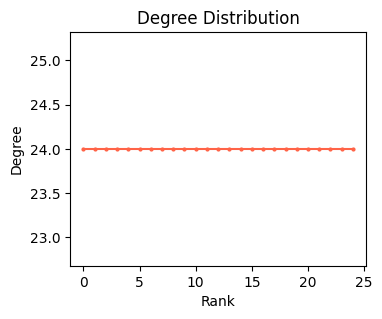

In [34]:
from frontend import visualise_features

visualise_features(collab_features)

# 2. Find Top Superheroes

## 2.1 Functionality

This function takes in input a graph, a specific node, the metric we want to use and the number of top heros we want to analyze. The function will return the metric values for the top N heros and in particular for the selected node. The metrics that you can choose are betweenness centrality, pagerank, closeness centrality and degree centrality.

In [35]:
metric = 'betweenness_centrality'
graph_metrics, node_metrics = collab_controller.run('metrics', top_n=50, node='WOLVERINE/LOGAN', metric=metric)

**Betweenness centrality** is a measure of how often a node acts as a bridge along the shortest path between two other nodes. A high betweenness centrality value suggests that the node is influential in connecting other nodes in the graph instead, if it's low, it may mean that the user is less connected to other nodes in the network.

A node with a high **PageRank** score is considered more important than a node with a low score and it may mean that they are influential within the network and are frequently linked to by other nodes.

A node with a high **closeness centrality** is able to reach other nodes in the graph more quickly than a node with a low closeness centrality so it may mean that they are well-connected to other nodes and have a central role within the network.

**Degree centrality** is a measure of how many other nodes a node is connected to so a node with a high degree centrality means that is well-connected within the network and has many connections to other nodes.

For example an high PageRank value and, at the same time, a low betweenness centrality, may mean that it's an important hero within the Marvel universe, but may not play as significant a role in connecting other heroes or groups within the network.

## 2.2 Visualisation
In the table below, we see the average betweenness centrality for the top 50 heroes and for WOLVERINE/LOGAN. The value is higher for WOLVERINE/LOGAN.

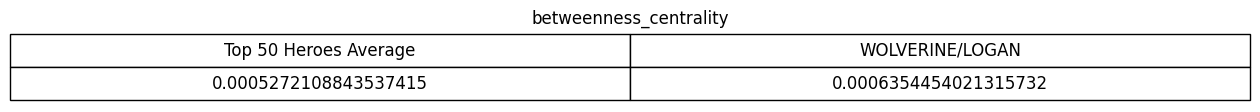

In [36]:
from frontend import visualise_metrics

visualise_metrics(graph_metrics=graph_metrics, node_metrics=node_metrics, metric=metric)

# 3. Shortest Ordered Route

## 3.1 Functionality

We want to find the minimum path between two heroes in terms of comics, with the constraint that we must visit, in order, other intermediate nodes. <br>

To implement this algorithm, we split the problem into smaller problems, searching for the minimum path between Node_0 and Node_1, then between Node_1 and Node_2, and so on, until we reach Node_n. <br>
This algorithm fails only in the case where the graph is disconnected, in which case it reports an error. <br>

In the visualization part, we report the information we are interested in. Specifically, we print on the screen the comic books that we will have to read if we want to meet our heroes in the given order, and then we plot a graph containing the hero-comic book connections in question. <br>

In [37]:
shortest_path = hero_comic_controller.run('shortest_order_route', top_n=100, initial_hero = 'SPIDER-MAN/PETER PARKER', final_hero = 'CYCLOPS/SCOTT SUMMER', superheroes = ["BLACK WIDOW/NATASHA",'CAPTAIN AMERICA', 'HUMAN TORCH/JOHNNY S', 'HULK/DR. ROBERT BRUC'], hero_comic =  'data/edges.csv')

## 3.2 Visualisation

The shortest path in terms of comics is: ['A 221', 'A 111', 'A 118', 'A 118', 'A 3']

***************************************************************************



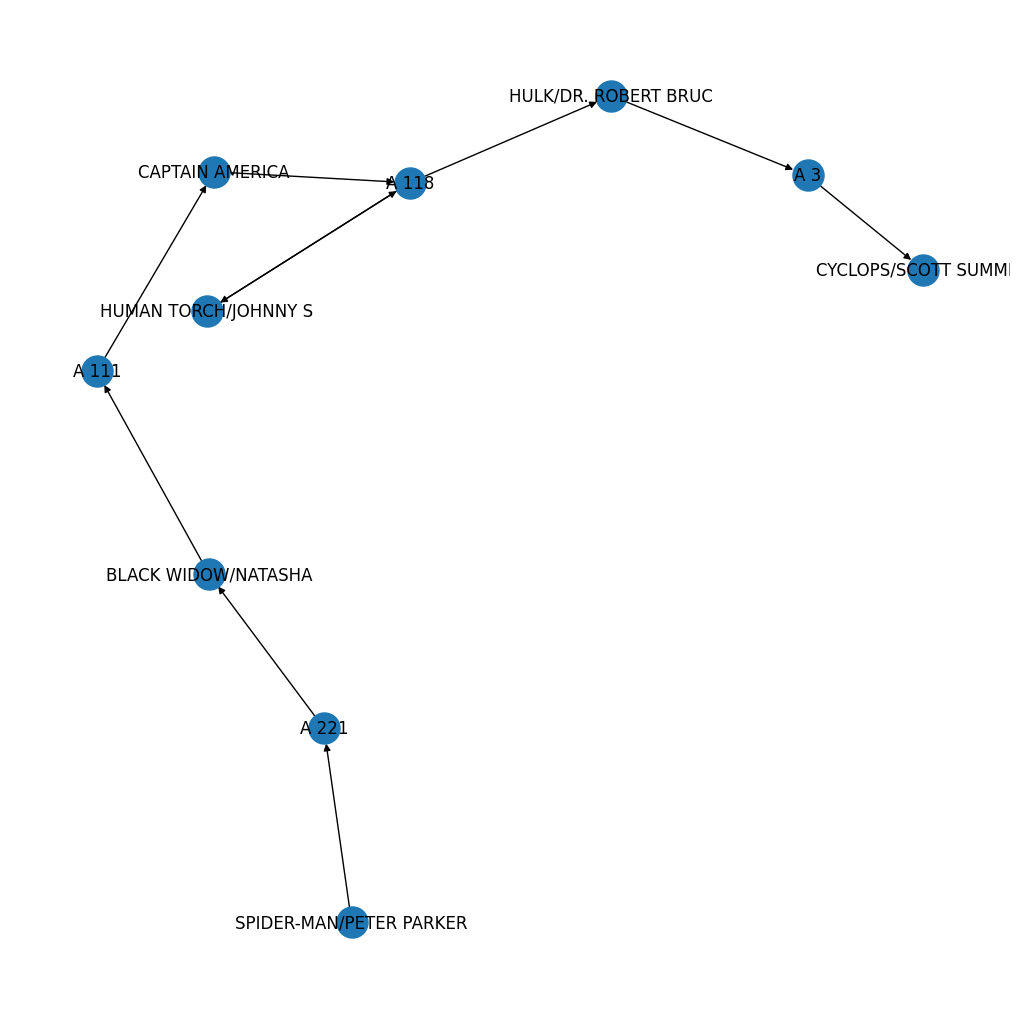

<Figure size 500x500 with 0 Axes>

In [38]:
from frontend import visualize_shortest_path

visualize_shortest_path(shortest_path)

# 4. Disconnecting Graphs

## 4.1 Functionality
We run the `disconnected_graphs` functionality with the two heroes **SPIDER-MAN/PETER PARKER** and **WOLVERINE/LOGAN**, for the **top 25** heroes. The functionality returns a [Disconnection](backend/domain/disconnection.py) object object that contains:
* the edges that were disconnected
* the cumulative weight of the disconnected edges
* the original graph
* the hero_a
* the hero_b 
* the graph_a that contains hero_a
* the graph_b that contains hero_b

In [39]:
hero_a = 'SPIDER-MAN/PETER PARKER'
hero_b = 'WOLVERINE/LOGAN'

disconnection = collab_controller.run('disconnecting_graphs', top_n=25, hero_a=hero_a, hero_b=hero_b)

## 4.2 Visualisation

The `disconnected_graph` function from our `frontend` package uses the `disconnection` object to create two `pyvis` graphs and save them as `.html` files. We can then load these files and display them with the help of an `IPython IFrame`.

### Interactivity
You can drag the entire graph or individual nodes with your mouse. Scrolling down the `IFrame` you will find some options that let you set aspects of the graph, e.g. the **label size** of the nodes.

In [40]:
from frontend import visualise_disconnected_graph

message, original_graph_path, disconnected_graph_path = visualise_disconnected_graph(disconnection)

### Number of Links 
Since the graph of the **top 25** is a **complete** graph, we will need to remove **24** edges from the graph to disconnect the original graph.

In [41]:
print(message)

The number of edges that were removed from the original graph is: 24


### The Original Graph
In the **interactive** graph shown below, we can see that the original graph with the **top 25 heroes** is a **complete** graph. The two heroes *SPIDER-MAN/PETER PARKER* and *WOLVERINE/LOGAN* are coloured **red**.

**NOTE:** If you **cannot** see the hero names, scroll down the `IFrame` and change the **font size**.

In [42]:
from IPython.display import IFrame

IFrame(src=original_graph_path, width=1000, height=600)

### The Disconnected Graph

Because the original graph with the **top 25 heroes** is a **complete** graph (density is equal to 1), when disconnecting them we will end up with a **complete graph** with **24 heroes** and a graph with **only a single** node.

In [43]:
import networkx as nx
nx.density(disconnection.original_graph)

1.0

In [44]:
from IPython.display import IFrame

IFrame(src=disconnected_graph_path, width=1000, height=600)

# 5. Extracting Communities

## 5.1 Functionality
We run the `extract_communities` function for the **top 25** heroes with *CAPTAIN AMERICA* as `hero1` and *IRON MAN/TONY STARK* as `hero2`.

The `extract_communities` function returns a [Communities](backend/domain/communities.py) dataclass containing:
* the edges that were disconnected
* the original graph
* the hero_1
* the hero_2 
* the community_1 that contains hero_1
* the community_2 that contains hero_2
* whether the two heroes are in the same community

In [45]:
hero_1 = 'CAPTAIN AMERICA'
hero_2 = 'IRON MAN/TONY STARK'
comms = collab_controller.run('extract_communities', top_n=25, hero_1=hero_1, hero_2=hero_2)

## 5.2 Visualisation

The `visualise_communities` function from the [frontend](frontend) package generates the visualisation outputs for the extracted communities object. It returns:
* a message about the number of removed links
* a table with the two communities
* a path to the original graph
* a path to a graph with the two communities coloured in
* a path to a graph with the communities of the heroes coloured in

Again, the graphs are `.html` files that are generated with the `pyvis` package.

In [46]:
%%capture
from frontend import visualise_communities

message, table, comms_original_graph_path, communities_graph_path, comms_final_graph_path = visualise_communities(comms)

### Links Removed
Like with the [disconnected graphs](#Disconnected-Graph), since we have a complete graph, the best way to split it is to remove **24** edges.

In [47]:
print(message)

The number of links that should be removed to have two communities is: 24.


### Communities Table
The table below shows the two generated communities with their heroes. As in [Disconnecting Graph](#Disconnecting-Graph), the split is as **uneven** as it possibly can be, with **one hero** in Community 1 and **the rest** in Community 2. We also observe that the two chosen heroes: **CAPTAIN AMERICA** and **IRON MAN/TONY STARK** ended up in the same community.

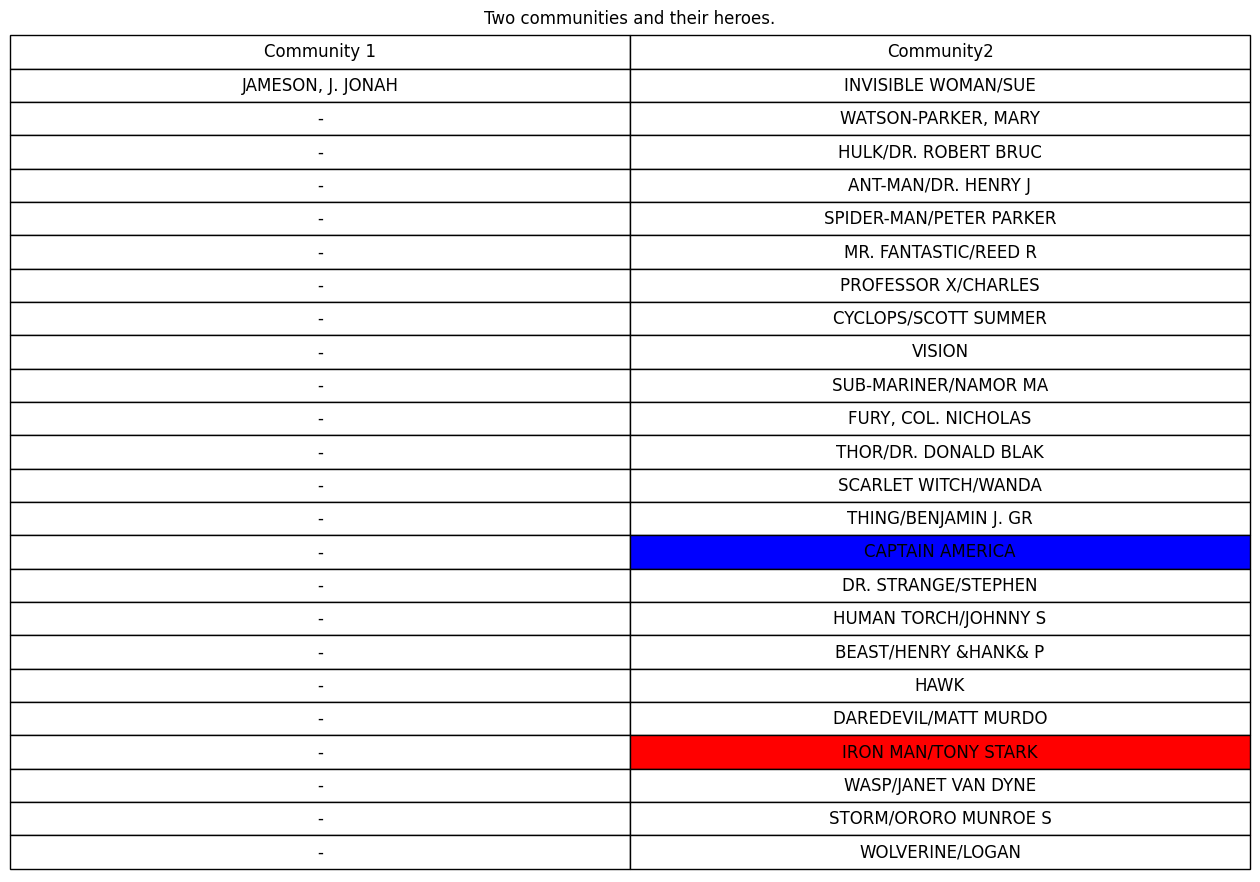

In [48]:
table

### Original Graph
The graph below is the original graph of the **top 25** heroes. Again, when scrolling down the frame, there are some settings that can be adjusted, e.g. font size.

In [49]:
IFrame(src=comms_original_graph_path, width=1000, height=600)

### Communities Graph
The graph below shows the two communities: **Community 1 (red)** and **Community 2 (blue)**. It shows what the communities table already showed, namely the fact that the two communities are **extremely imbalanced** due to the fact that the graph is so **densely connected**.

In [50]:
IFrame(src=communities_graph_path, width=1000, height=600)

### Final Graph
The last graph shows the actual communities that hero 1 and hero 2 belong to. The graph can take the following colours:

* green - the community that contains **both hero 1 and hero 2**.
* blue - the community that contains **hero 1 ONLY** (not present in this graph because both heroes are in the same community)
* red - the community that contains **hero 2 ONLY** (not present in this graph because both heroes are in the same community)
* yellow - the community that contains **neither hero 1 nor hero 2**.

In [51]:
IFrame(src=comms_final_graph_path, width=1000, height=600)

---

# Algorithmic Question

## Data Structure
This solution to the algorithmic question uses a **MultiDiGraph**:
* multi - multiple edges between nodes
* di - directed

The idea is that the **poly-line** in the **3 by 3 password grid** can be represented as a **MultiDiGraph**. Each point in the password grid is a **node**, and each line that can be drawn from a point to another is an **edge**. Because only vertical and horizontal lines are allowed, this gives a graph with **9 nodes** and **24 edges**. 

![password_grid_graph](doc/q_algo_multidigraph.png)

For example, if we start from **node 0**, we can go to **node 1** or **node 3**. Additionally, each edge has a label `direction` with a single character `{'D', 'U', 'L', 'R'}` which indicates the direction that the edge is going to. For example, the edge **(0, 1)** is labeled with `direction=R`, but the edge **(1, 0)** is labelled with `direction=L`.

## Creating the Graph
As a first step, we have to create the graph. We have to add **9 nodes** and **24 edges**. Creating the edges requires to determine the neighbours of each node in the graph and which direction they should be assigned.

In [52]:
import networkx as nx
g = nx.MultiDiGraph()
g.add_nodes_from(range(9))

### Neighbours
We know that **0** should be connected to **1** and to **3**. To determine that **1** and **3** are the neighbours of **0**, we have a 3 by 3 numpy array which represents the password grid. By adding a delta of **(0, 1)** to the **row** and **column** of **0** we know that we will be moving to the right, as the **column** value is increased by 1 but the row value remains the same.

```python
0_row_col = (0, 0)
right_neighbour = 0_row_col + (0, 1) # the row and column of the neighbour to the right
```

By doing this for all 4 directions and only keeping those neighbours that are also in the grid, e.g. moving to the left of **node 0** is not possible, we end up with all of the edges that we need.

In [53]:
nodes = np.arange(9).reshape((3, 3))
valid_coords = [(x, y) for x in range(nodes.shape[0]) for y in range(nodes.shape[1])]

NameError: name 'np' is not defined

In [ ]:
def neighbours(n, nodes):
    """Determines the neighbours of n in the nodes array.
    
    :arg
    n - the node to find neighbours for
    nodes - a numpy array.
    
    :return
    a generator with the neighbouring nodes and their directions.
    
    Example:
    list(neighbours(4, nodes))
    [(5, 'R'), (3, 'L'), (7, 'D'), (1, 'U')]
    """
    neighs = []
    row_col = np.array(np.where(nodes == n)).flatten()
    
    for delta, direction in [((0, 1), 'R'), ((0, -1), 'L'), ((1, 0), 'D'), ((-1, 0), 'U')]:
        
        new_row_col = tuple(row_col + delta)
        if new_row_col in valid_coords:
            yield nodes[new_row_col], direction

Find the neighbours for each node in the graph, and add them as edges one by one.

In [ ]:
for node in g.nodes():
    for neighbour, direction in neighbours(node, nodes):
        g.add_edge(node, neighbour, direction=direction)

In [ ]:
nx.draw(g, with_labels=True)

## Finding all direction sequences
The input is a single string that shows **just** the direction of the segment lines, i.e. **D** can mean to go down **one** node or **two** nodes. If we find **all possible sequences of directions** from the input, we can then use those to traverse the graph and see whether we manage to follow the sequence without revisiting nodes or trying to go into a direction that is not possible.

For example, the string `DRU` gives the following possible sequences:
```
['DRU', 'DRUU', 'DRRU', 'DRRUU', 'DDRU', 'DDRUU', 'DDRRU', 'DDRRUU']
```



In [ ]:
def all_sequences(directions, max_steps=2):
    """Finds all possible sequences given a string of directions.
    
    :arg
    directions (str) - the directions
    max_steps (int) - determines the number of possible steps that you can take in a single direction.
    
    :return
    a generator with a single sequence.
    """
    steps = []
    for direction in directions:
        step = [(i + 1)* direction for i in range(max_steps)]
        steps.append(tuple(step))
        
    indeces = list(itertools.product(range(2), repeat=len(directions)))
    all_steps = []
    for ind in indeces:
        step = []
        for i, s in zip(ind, range(len(steps))):
            step.append(steps[s][i])
            
        yield "".join(step)

## The Algorithm
To find solutions from an input string, we need to try to walk **all possible sequences** starting from **all nodes in the graph**. If we are able to finish a walk, we increment our count by one.

In [ ]:
def password_possibilities(directions):
    for i in range(len(directions) - 1):
        if directions[i] == directions[i + 1]:
            raise ValueError(f"Found consecutive repeating characters: {directions[i], directions[i + 1]} in {directions}")
    
    solutions = 0
    for steps in all_sequences('DRU'):
        for start in g.nodes():

            current_node = start
            steps_path = list(steps)
            visited = {current_node}

            while steps_path:

                step = steps_path[0]
                edge = list(filter(lambda e: e[-1] == step, g.out_edges(current_node, data='direction')))

                # if there is an edge to take into the next direction and we haven't visited the node on the other side of the edge
                # so far.
                if edge and edge[0][1] not in visited:
                    # move to the next node
                    current_node = edge[0][1]
                    visited.add(current_node)
                    steps_path.pop(0)

                else:
                    # it is not possible to take the next direction or we have visited a node already, so the path is not possible
                    break
            if not steps_path:
                solutions += 1
    return solutions

In [ ]:
password_possibilities('DRU')

In [ ]:
password_possibilities('R')

In [ ]:
password_possibilities('LDRDRUL')